## PREGUNTA DE NEGOCIO SEMANA 3

<b>¿Hay una relación entre el precio del alojamiento y la satisfacción general de los clientes? ¿Cómo varía esta relación entre las ciudades?</b>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import shapiro
from scipy.stats import pearsonr, spearmanr
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',  40)

In [3]:
df = pd.read_csv('tourist_accommodation_10112025_clean.csv')
df.head()

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date,is_valid,ocupacion_mes
0,11964,A ROOM WITH A VIEW,Private bedroom in our attic apartment. Right ...,45553,Centro,NaN,Private room,2,2,1.0,1.0,"TV,Internet,Wifi,Air conditioning,Elevator,Buz...",400.0,3,365,True,7,20,40,130,78.0,2010-02-01,2017-05-09,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0.406109,Spain,Málaga,2018-07-31,True,23
1,21853,Bright and airy room,We have a quiet and sunny room with a good vie...,83531,Cármenes,Latina,Private room,1,1,1.0,1.0,"TV,Internet,Wifi,Air conditioning,Kitchen,Free...",170.0,4,40,True,0,0,0,162,33.0,2014-10-10,NaN,92.0,9.0,9.0,10.0,10.0,8.0,9.0,0,0.244444,Spain,Madrid,2020-01-10,True,30
2,32347,Explore Cultural Sights from a Family-Friendly...,Open French doors and step onto a plant-filled...,139939,San Vicente,Casco Antiguo,Entire home/apt,4,1,2.0,2.0,"TV,Internet,Wifi,Air conditioning,Wheelchair a...",990.0,2,120,True,26,31,31,270,148.0,2011-05-01,NaN,98.0,10.0,10.0,10.0,10.0,10.0,10.0,1,0.836473,Spain,Sevilla,2019-07-29,True,4
3,35379,Double 02 CasanovaRooms Barcelona,Room at a my apartment. Kitchen and 2 bathroom...,152232,L'Antiga Esquerra De L'Eixample,Eixample,Private room,2,2,1.0,1.0,"TV,Internet,Wifi,Kitchen,Breakfast,Elevator,Bu...",400.0,2,730,True,9,23,49,300,292.0,NaN,2020-04-01,94.0,10.0,9.0,10.0,10.0,10.0,9.0,1,4.273171,Spain,Barcelona,2020-01-10,True,21
4,35801,Can Torras Farmhouse Studio Suite,Lay in bed & watch sunlight change the mood of...,153805,Quart,NaN,Private room,5,1,2.0,5.0,"Wifi,Pool,Free parking on premises,Breakfast,P...",900.0,1,180,True,0,19,49,312,36.0,2011-08-07,2018-08-08,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0.207294,Spain,Girona,2019-02-19,True,30


In [35]:
# Verificar columnas
print("Columnas en el DataFrame:")
print(df.columns.tolist())

# Verificar valores faltantes
print("\nValores faltantes por columna:")
print(df.isnull().sum())

# Verificar duplicatas
print(f"\nNúmero de duplicadas: {df.duplicated().sum()}")

# Filtrar valores inválidos de precio y evaluación
# Eliminar registros donde review_scores_rating es 0 o NaN
df_clean = df.dropna(subset=['review_scores_rating']).copy()
df_clean = df_clean[df_clean['review_scores_rating'] > 0]

# Eliminar registros donde price es 0, negativo o NaN
df_clean = df_clean.dropna(subset=['price'])
df_clean = df_clean[df_clean['price'] > 0]

# Verificar valores extremos (outliers) en 'price' y 'review_scores_rating'
Q1_price = df_clean['price'].quantile(0.25)
Q3_price = df_clean['price'].quantile(0.75)
IQR_price = Q3_price - Q1_price
limite_superior_price = Q3_price + 1.5 * IQR_price

print(f"\nNúmero de registros después de la limpieza (precio y evaluación > 0): {len(df_clean)}")

df = df_clean

Columnas en el DataFrame:
['apartment_id', 'name', 'description', 'host_id', 'neighbourhood_name', 'neighbourhood_district', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'amenities_list', 'price', 'minimum_nights', 'maximum_nights', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'first_review_date', 'last_review_date', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'is_instant_bookable', 'reviews_per_month', 'country', 'city', 'insert_date', 'is_valid', 'ocupacion_mes', 'price_quantil', 'price_sq']

Valores faltantes por columna:
apartment_id                      0
name                              3
description                     127
host_id                           0
neighbourhood_name                0
neighbourhood_district         3654
room_type              

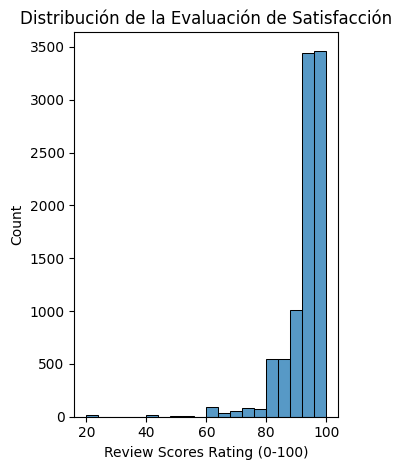

In [37]:
# Distribución de la evaluación
plt.subplot(1, 2, 2)
sns.histplot(df['review_scores_rating'], bins=20, kde=False)
plt.title('Distribución de la Evaluación de Satisfacción')
plt.xlabel('Review Scores Rating (0-100)')
plt.tight_layout()
plt.show()

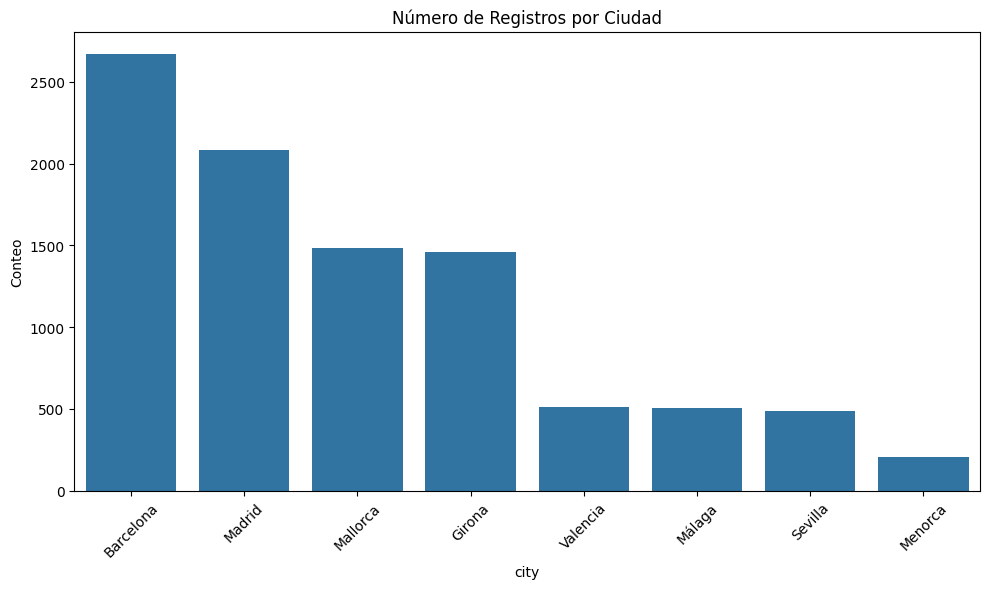


Conteo de registros por ciudad:
city
Barcelona    2673
Madrid       2083
Mallorca     1485
Girona       1459
Valencia      510
Málaga        503
Sevilla       486
Menorca       207
Name: count, dtype: int64


In [38]:
# Conteo de registros por ciudad
plt.figure(figsize=(10, 6))
city_counts = df['city'].value_counts()
sns.barplot(x=city_counts.index, y=city_counts.values)
plt.title('Número de Registros por Ciudad')
plt.xticks(rotation=45)
plt.ylabel('Conteo')
plt.tight_layout()
plt.show()
print("\nConteo de registros por ciudad:")
print(city_counts)

# Análisis de la Relación General (Precio vs. Satisfacción)


Correlación de Pearson entre Precio y Evaluación (General): 0.0699


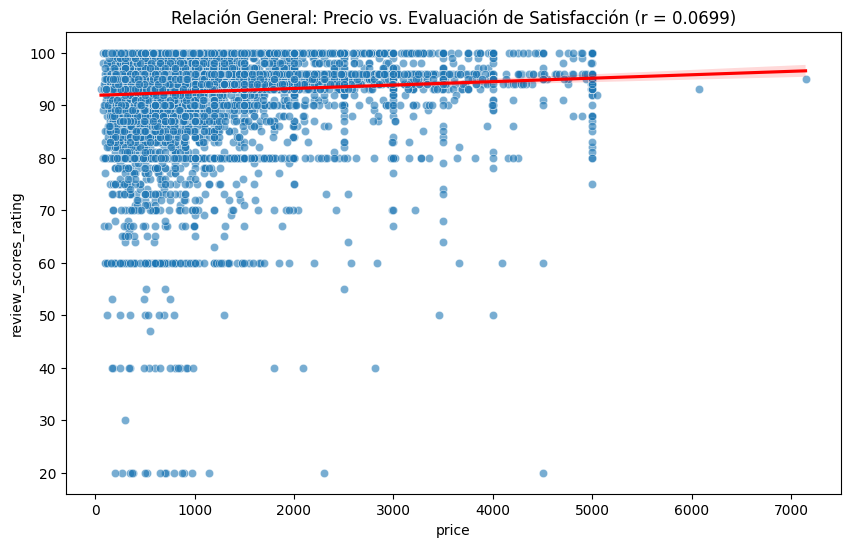

In [39]:
# Calcular correlación de Pearson
correlation_general = df_clean['price'].corr(df_clean['review_scores_rating'])
print(f"\nCorrelación de Pearson entre Precio y Evaluación (General): {correlation_general:.4f}")

# Gráfico de dispersión general
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='price', y='review_scores_rating', alpha=0.6)
plt.title(f'Relación General: Precio vs. Evaluación de Satisfacción (r = {correlation_general:.4f})')
plt.xlabel('Precio (€)')
plt.ylabel('Evaluación de Satisfacción (0-100)')

# Agregar línea de regresión
sns.regplot(data=df_clean, x='price', y='review_scores_rating', scatter=False, color='red')
plt.show()

# Análisis de la Relación por Ciudad


Correlación entre Precio y Evaluación por Ciudad:
        city  correlation
0  Barcelona    -0.035707
1     Girona     0.102126
2     Madrid     0.056348
3   Mallorca     0.095392
4    Menorca     0.098281
5     Málaga     0.105396
6    Sevilla     0.019389
7   Valencia     0.044276


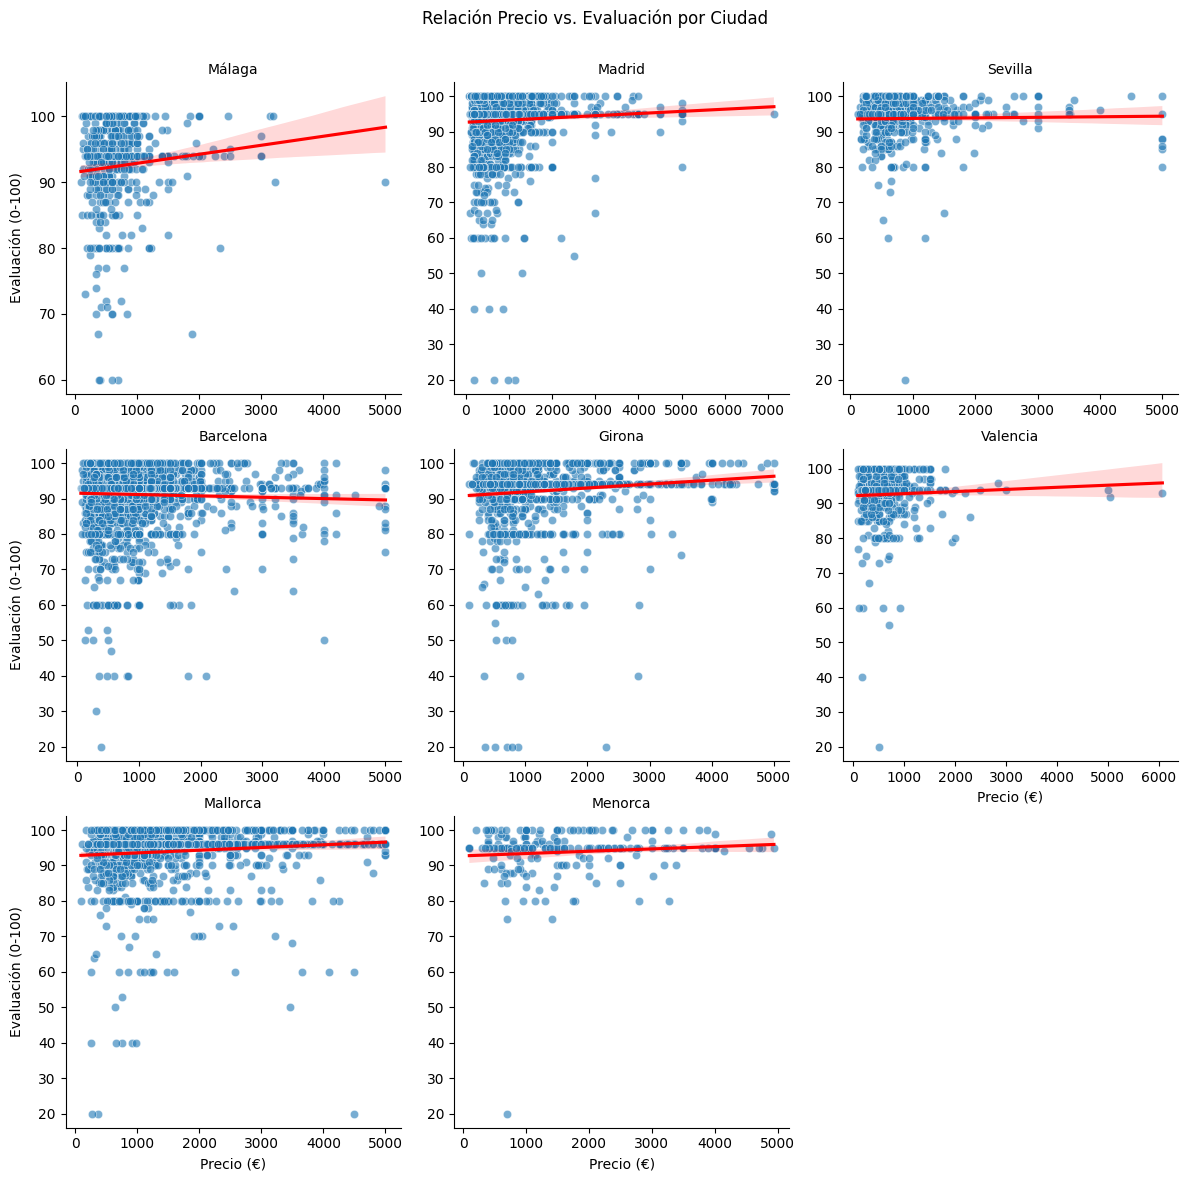

In [40]:
# Calcular correlación por ciudad
correlations_by_city = df_clean.groupby('city').apply(lambda x: x['price'].corr(x['review_scores_rating'])).reset_index()
correlations_by_city.columns = ['city', 'correlation']
print("\nCorrelación entre Precio y Evaluación por Ciudad:")
print(correlations_by_city)

# Gráfico de dispersión facetado por ciudad
# Usando FacetGrid de Seaborn
g = sns.FacetGrid(df_clean, col='city', col_wrap=3, height=4, sharex=False, sharey=False)
g.map(sns.scatterplot, 'price', 'review_scores_rating', alpha=0.6)
g.map(sns.regplot, 'price', 'review_scores_rating', scatter=False, color='red')
g.set_axis_labels('Precio (€)', 'Evaluación (0-100)')
g.set_titles('{col_name}')
plt.subplots_adjust(top=0.92)
g.fig.suptitle('Relación Precio vs. Evaluación por Ciudad')
plt.show()

In [43]:
from statsmodels.formula.api import ols

# Preparar los datos para statsmodels (agregando constante)
# df_for_regression = df_clean[['price', 'city', 'review_scores_rating']].copy()
# model_interaction = ols('review_scores_rating ~ price * C(city)', data=df_for_regression).fit()

# Alternativamente, usando statsmodels directamente con fórmula:
# La interacción es representada por price:C(city)
formula_interaction = 'review_scores_rating ~ price * C(city)'
model_interaction = ols(formula_interaction, data=df).fit()

print("\nResumen de la Regresión con Interacción (Precio * Ciudad):")
print(model_interaction.summary())

# Interpretar los coeficientes de interacción es complejo.
# Una abordaje más práctica es correr regresiones separadas por ciudad o usar contrastes.
# Vamos a intentar una regresión simple de precio por ciudad y plotear los coeficientes.


Resumen de la Regresión con Interacción (Precio * Ciudad):
                             OLS Regression Results                             
Dep. Variable:     review_scores_rating   R-squared:                       0.022
Model:                              OLS   Adj. R-squared:                  0.020
Method:                   Least Squares   F-statistic:                     13.87
Date:                  Thu, 13 Nov 2025   Prob (F-statistic):           1.35e-35
Time:                          11:30:01   Log-Likelihood:                -32903.
No. Observations:                  9406   AIC:                         6.584e+04
Df Residuals:                      9390   BIC:                         6.595e+04
Df Model:                            15                                         
Covariance Type:              nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------


Coeficiente de Precio y P-Valor por Ciudad (de la regresión simple):
        city     slope   p_value
0  Barcelona -0.000382  0.064918
1     Girona  0.001106  0.000093
2     Madrid  0.000613  0.010105
3   Mallorca  0.000761  0.000232
4    Menorca  0.000652  0.158875
5     Málaga  0.001372  0.018054
6    Sevilla  0.000158  0.669839
7   Valencia  0.000611  0.318314


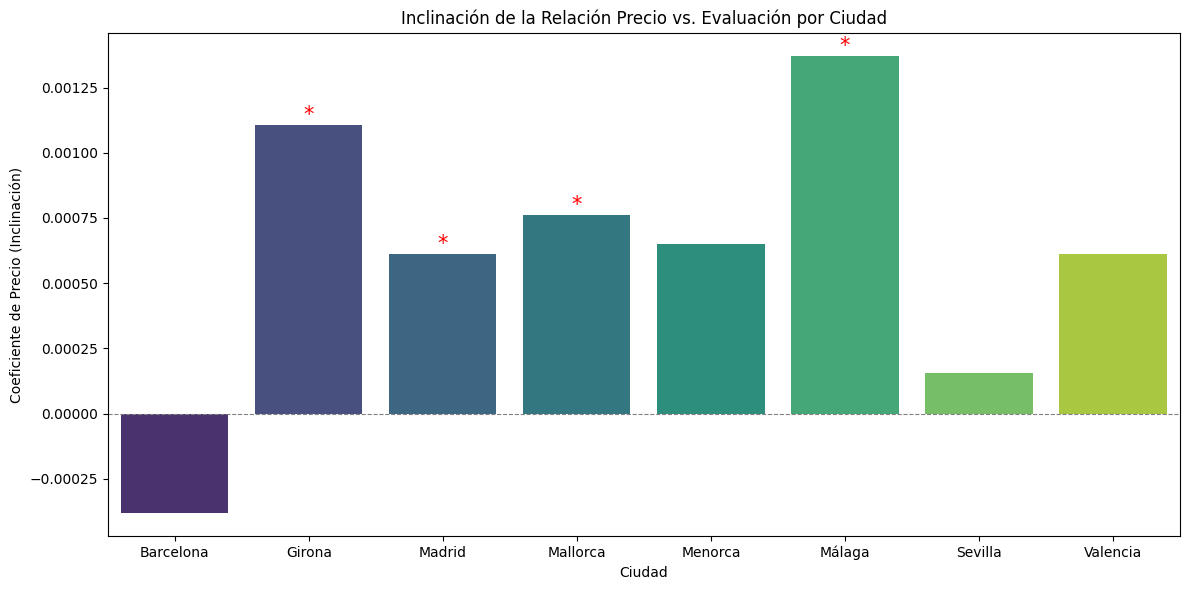

In [44]:
# Función para calcular la regresión lineal simple y retornar el coeficiente de precio y p-valor
def get_price_coef_and_pval(group):
    if len(group) < 2: # Necesario al menos 2 puntos para regresión
        return pd.Series({'slope': np.nan, 'p_value': np.nan})
    y = group['review_scores_rating']
    X = group['price']
    X_with_const = sm.add_constant(X)
    model = sm.OLS(y, X_with_const).fit()
    slope = model.params['price']
    p_val = model.pvalues['price']
    return pd.Series({'slope': slope, 'p_value': p_val})

# Aplicar la función a cada grupo de ciudad
city_results = df_clean.groupby('city').apply(get_price_coef_and_pval).reset_index()

print("\nCoeficiente de Precio y P-Valor por Ciudad (de la regresión simple):")
print(city_results)

# Gráfico de barras de los coeficientes de inclinación
plt.figure(figsize=(12, 6))
bars = sns.barplot(data=city_results, x='city', y='slope', palette='viridis')
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8) # Línea horizontal en 0
plt.title('Inclinación de la Relación Precio vs. Evaluación por Ciudad')
plt.xlabel('Ciudad')
plt.ylabel('Coeficiente de Precio (Inclinación)')

# Agregar anotaciones de significancia (opcional)
for index, row in city_results.iterrows():
    if not pd.isna(row['p_value']) and row['p_value'] < 0.05:
        plt.text(index, row['slope'], '*', ha='center', va='bottom', fontsize=15, color='red')

plt.tight_layout()
plt.show()


Correlación de Spearman entre Precio y Evaluación (General): 0.1127


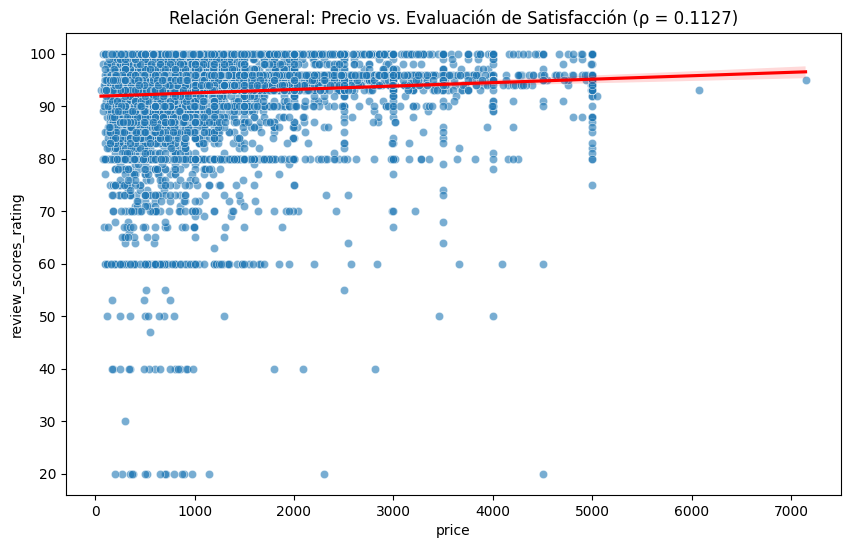

In [45]:
# Análisis de la Relación General (Precio vs. Satisfacción)
# Esta acción calcula la correlación de Spearman entre precio y evaluación para todos los datos y crea un gráfico de dispersión general.
correlation_general = df_clean['price'].corr(df_clean['review_scores_rating'], method='spearman')
print(f"\nCorrelación de Spearman entre Precio y Evaluación (General): {correlation_general:.4f}")

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='price', y='review_scores_rating', alpha=0.6)
plt.title(f'Relación General: Precio vs. Evaluación de Satisfacción (ρ = {correlation_general:.4f})')
plt.xlabel('Precio (€)')
plt.ylabel('Evaluación de Satisfacción (0-100)')

sns.regplot(data=df_clean, x='price', y='review_scores_rating', scatter=False, color='red')
plt.show()


Correlación de Spearman entre Precio y Evaluación por Ciudad:
        city  spearman_correlation
0  Barcelona             -0.044391
1     Girona              0.130911
2     Madrid              0.062376
3   Mallorca              0.144250
4    Menorca              0.028974
5     Málaga              0.146747
6    Sevilla              0.072713
7   Valencia              0.071469


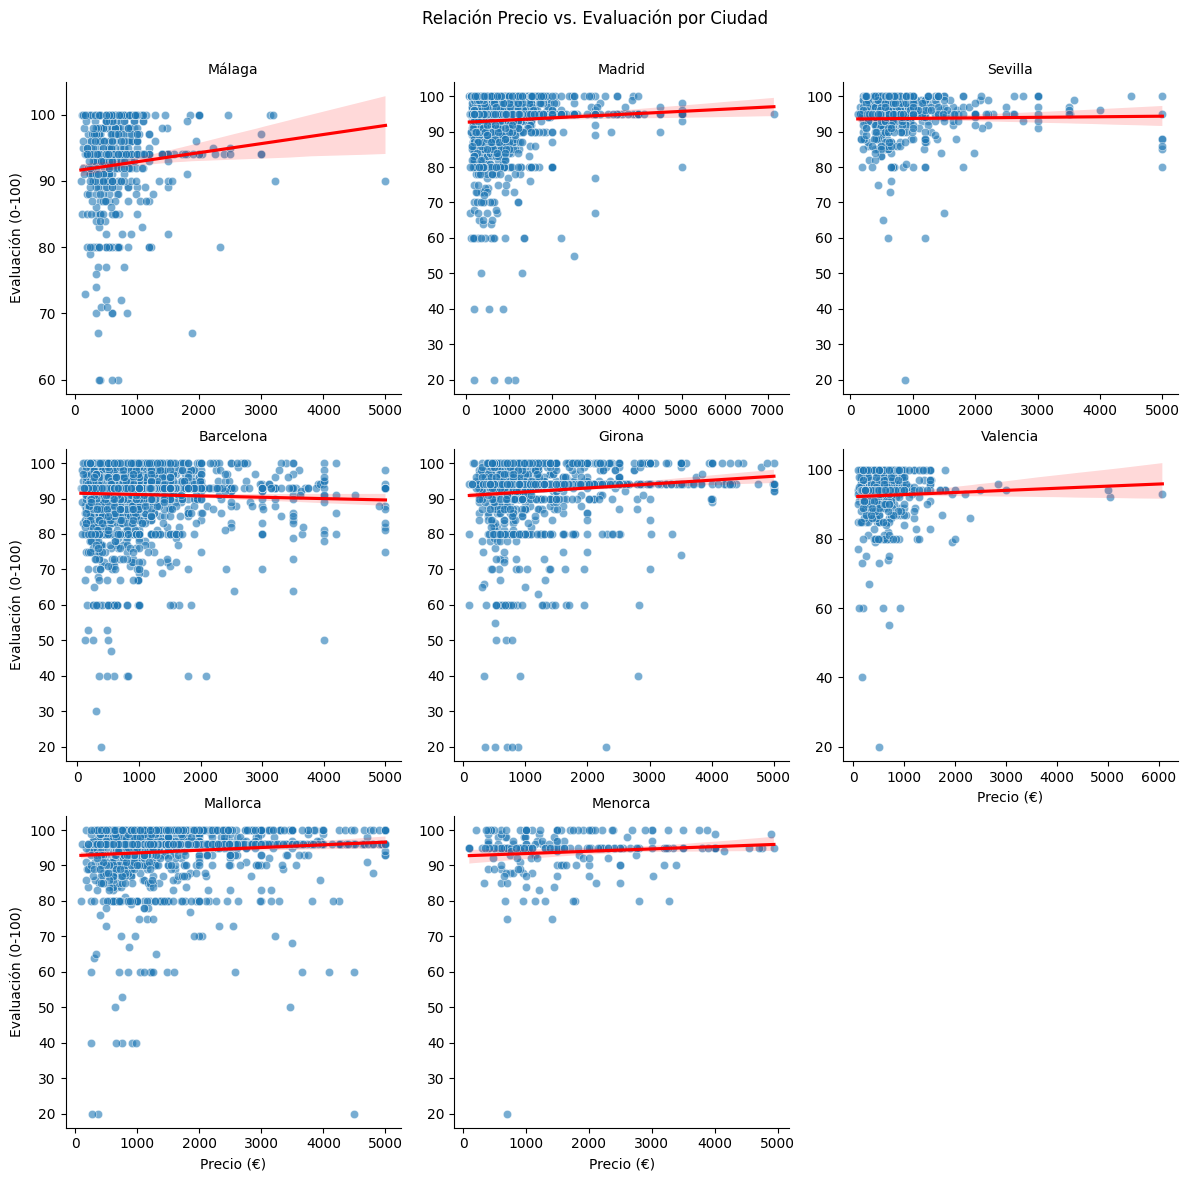

In [46]:
# Análisis de la Relación por Ciudad
# Esta acción calcula la correlación de Spearman entre precio y evaluación para cada ciudad y crea gráficos de dispersión facetados por ciudad.
correlations_by_city = df_clean.groupby('city').apply(lambda x: x['price'].corr(x['review_scores_rating'], method='spearman')).reset_index()
correlations_by_city.columns = ['city', 'spearman_correlation']
print("\nCorrelación de Spearman entre Precio y Evaluación por Ciudad:")
print(correlations_by_city)

g = sns.FacetGrid(df_clean, col='city', col_wrap=3, height=4, sharex=False, sharey=False)
g.map(sns.scatterplot, 'price', 'review_scores_rating', alpha=0.6)
g.map(sns.regplot, 'price', 'review_scores_rating', scatter=False, color='red')
g.set_axis_labels('Precio (€)', 'Evaluación (0-100)')
g.set_titles('{col_name}')
plt.subplots_adjust(top=0.92)
g.fig.suptitle('Relación Precio vs. Evaluación por Ciudad')
plt.show()

In [47]:
# Regresión Lineal con Interacción (Precio * Ciudad)
# Esta acción ajusta un modelo de regresión lineal que incluye la interacción entre precio y ciudad.
# Esto permite evaluar si la relación entre precio y evaluación varía significativamente entre ciudades.
formula_interaction = 'review_scores_rating ~ price * C(city)'
model_interaction = ols(formula_interaction, data=df_clean).fit()

print("\nResumen de la Regresión con Interacción (Precio * Ciudad):")
print(model_interaction.summary())


Resumen de la Regresión con Interacción (Precio * Ciudad):
                             OLS Regression Results                             
Dep. Variable:     review_scores_rating   R-squared:                       0.022
Model:                              OLS   Adj. R-squared:                  0.020
Method:                   Least Squares   F-statistic:                     13.87
Date:                  Thu, 13 Nov 2025   Prob (F-statistic):           1.35e-35
Time:                          11:33:58   Log-Likelihood:                -32903.
No. Observations:                  9406   AIC:                         6.584e+04
Df Residuals:                      9390   BIC:                         6.595e+04
Df Model:                            15                                         
Covariance Type:              nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------


Coeficiente de Precio y P-Valor por Ciudad (de la regresión simple):
        city     slope   p_value
0  Barcelona -0.000382  0.064918
1     Girona  0.001106  0.000093
2     Madrid  0.000613  0.010105
3   Mallorca  0.000761  0.000232
4    Menorca  0.000652  0.158875
5     Málaga  0.001372  0.018054
6    Sevilla  0.000158  0.669839
7   Valencia  0.000611  0.318314


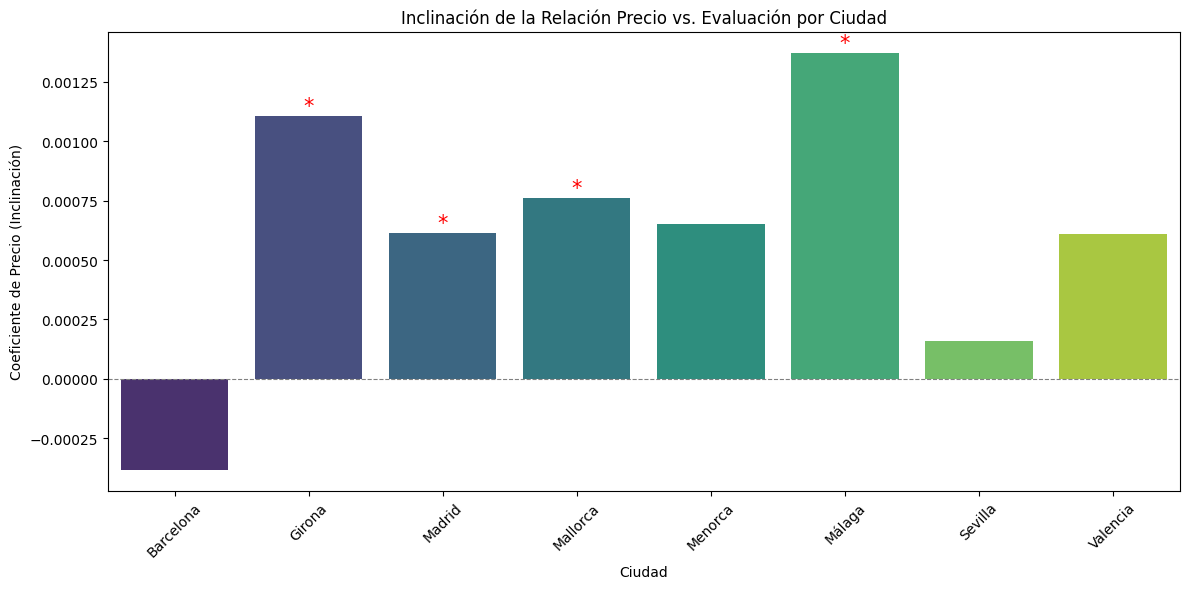

In [48]:
# Regresiones Simples por Ciudad (Alternativa a la Interacción)
# Esta acción ajusta una regresión lineal simple (solo precio) para cada ciudad y extrae el coeficiente de pendiente (inclinación de la relación precio-evaluación).
def get_price_coef_and_pval(group):
    # Esta función calcula la regresión lineal simple y retorna el coeficiente de precio y p-valor para un grupo de datos.
    if len(group) < 2: # Necesario al menos 2 puntos para regresión
        return pd.Series({'slope': np.nan, 'p_value': np.nan})
    y = group['review_scores_rating']
    X = group['price']
    X_with_const = sm.add_constant(X)
    model = sm.OLS(y, X_with_const).fit()
    slope = model.params['price']
    p_val = model.pvalues['price']
    return pd.Series({'slope': slope, 'p_value': p_val})

city_results = df_clean.groupby('city').apply(get_price_coef_and_pval).reset_index()

print("\nCoeficiente de Precio y P-Valor por Ciudad (de la regresión simple):")
print(city_results)

plt.figure(figsize=(12, 6))
bars = sns.barplot(data=city_results, x='city', y='slope', palette='viridis')
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8) # Línea horizontal en 0
plt.title('Inclinación de la Relación Precio vs. Evaluación por Ciudad')
plt.xlabel('Ciudad')
plt.ylabel('Coeficiente de Precio (Inclinación)')
plt.xticks(rotation=45)

# Agregar anotaciones de significancia (opcional)
for index, row in city_results.iterrows():
    if not pd.isna(row['p_value']) and row['p_value'] < 0.05:
        plt.text(index, row['slope'], '*', ha='center', va='bottom', fontsize=15, color='red')

plt.tight_layout()
plt.show()

## Distribución de rating por precio

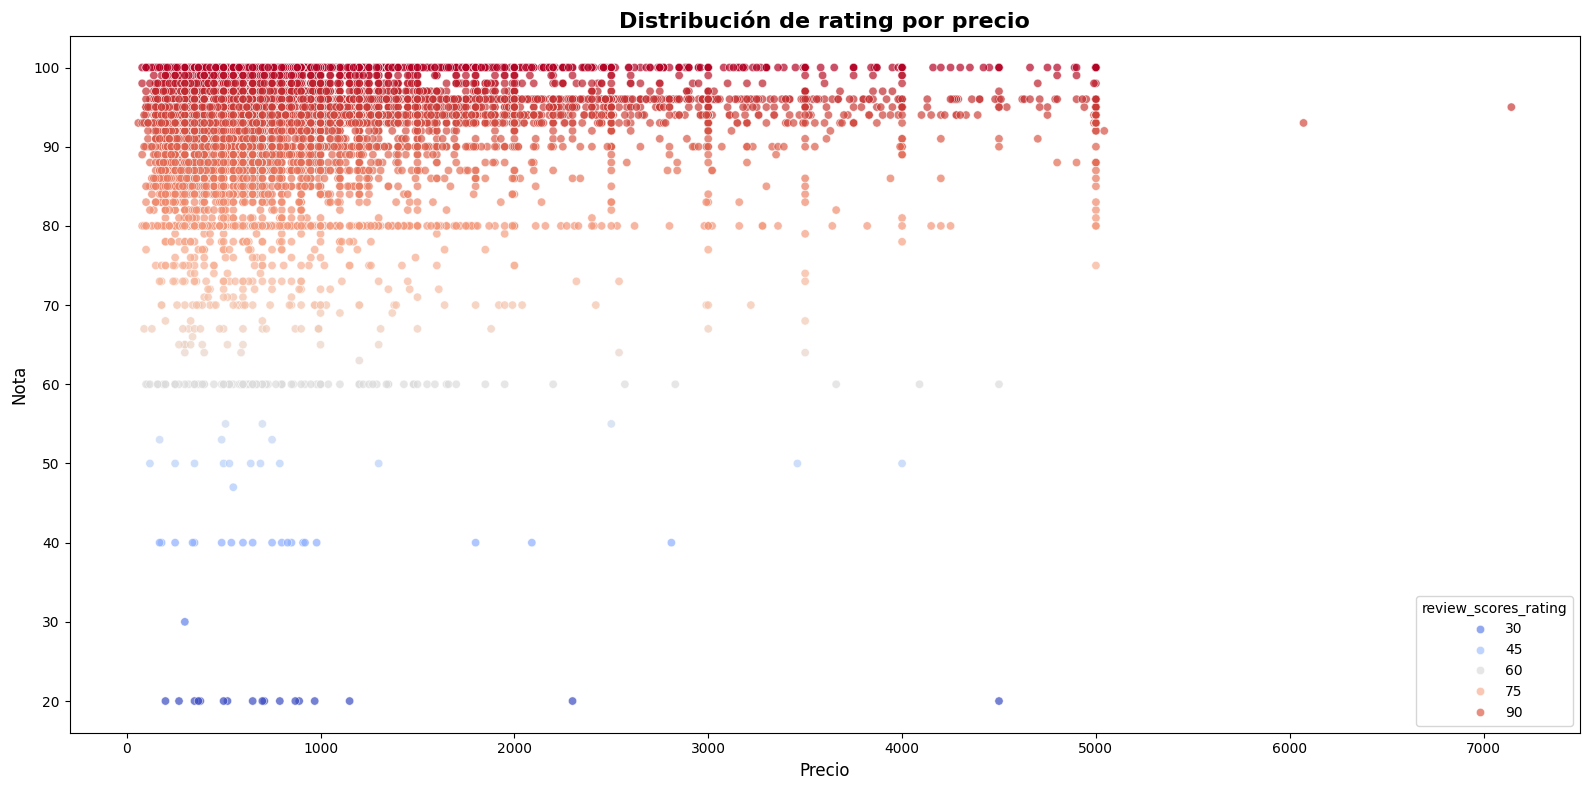

In [36]:
plt.figure(figsize=(16, 8))
sns.scatterplot(
    data=df,
    x='price',
    y='review_scores_rating',
    hue='review_scores_rating',
    palette='coolwarm',
    alpha=0.7,
    sizes=(10, 200)
)
plt.title("Distribución de rating por precio", fontsize=16, weight='bold')
plt.xlabel("Precio", fontsize=12)
plt.ylabel("Nota", fontsize=12)
plt.tight_layout()
plt.show()


## Distribución de precios por ciudad

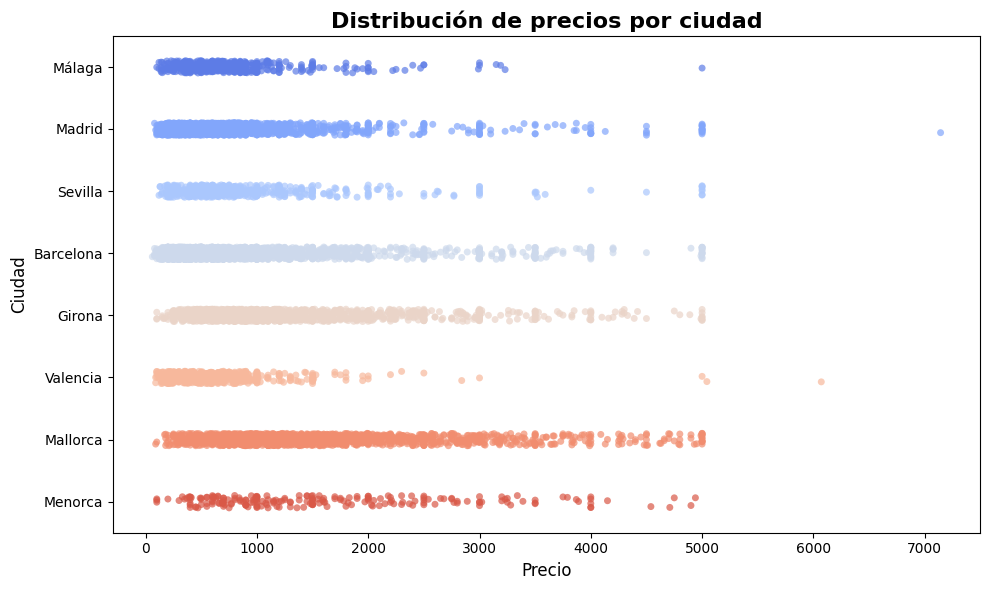

In [6]:
plt.figure(figsize=(10, 6))
sns.stripplot(
    data=df,
    x='price',
    y='city',
    jitter=True,
    alpha=0.7,
    palette='coolwarm'
)
plt.title("Distribución de precios por ciudad", fontsize=16, weight='bold')
plt.xlabel("Precio", fontsize=12),
plt.ylabel("Ciudad", fontsize=12),
plt.tight_layout()
plt.show()

## Distribución de rating por ciudad

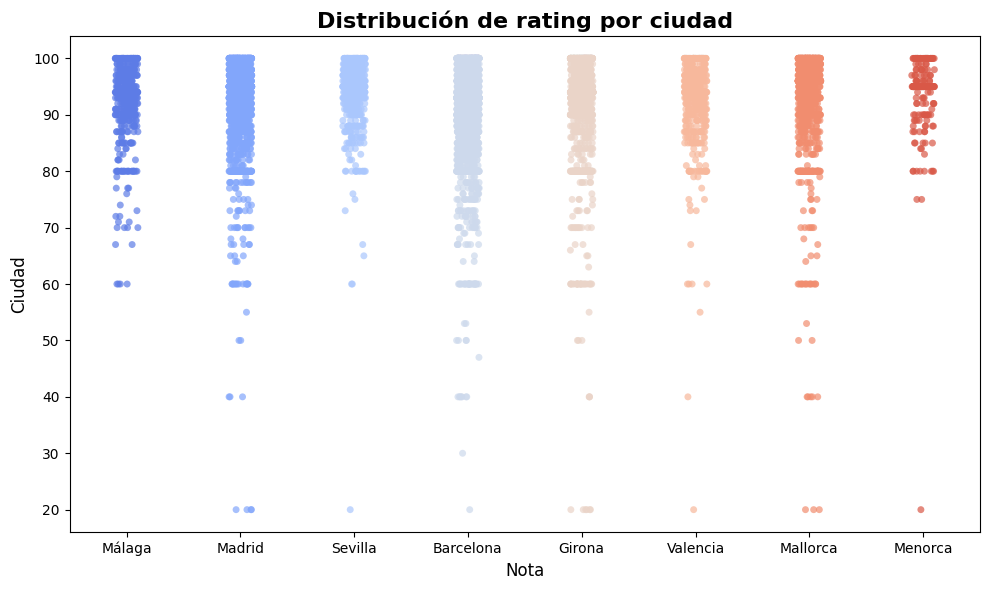

In [7]:
plt.figure(figsize=(10, 6))
sns.stripplot(
    data=df,
    x='city',
    y='review_scores_rating',
    jitter=True,
    alpha=0.7,
    palette='coolwarm'
)
plt.title("Distribución de rating por ciudad", fontsize=16, weight='bold')
plt.xlabel("Nota", fontsize=12),
plt.ylabel("Ciudad", fontsize=12),
plt.tight_layout()
plt.show()

In [8]:
df[['price', 'review_scores_rating']].corr()

,price,review_scores_rating
price,1.00000,0.06991
review_scores_rating,0.06991,1.00000


In [9]:
df.groupby('city')[['price', 'review_scores_rating']].corr().iloc[0::2,-1]

city            
Barcelona  price   -0.035707
Girona     price    0.102126
Madrid     price    0.056348
Mallorca   price    0.095392
Menorca    price    0.098281
Málaga     price    0.105396
Sevilla    price    0.019389
Valencia   price    0.044276
Name: review_scores_rating, dtype: float64

## Test de Shapiro

In [10]:
shapiro_price = shapiro(df['price'].sample(5000, random_state=42))
shapiro_rating = shapiro(df['review_scores_rating'].sample(5000, random_state=42))

print("Shapiro-Wilk para 'price':   W = %.3f, p = %.2f" % shapiro_price)
print("Shapiro-Wilk para 'rating':  W = %.3f, p = %.2f" % shapiro_rating)

Shapiro-Wilk para 'price':   W = 0.792, p = 0.00
Shapiro-Wilk para 'rating':  W = 0.717, p = 0.00


Ambos p-valores son prácticamente 0, lo que significa que tanto price como rating no siguen una distribución normal.
Spearman (rangos, no requiere normalidad) es más apropiado para nuestros datos.

## Test de Pearson y Spearman

In [11]:
# Pearson
pearson_corr, pearson_p = pearsonr(df['price'], df['review_scores_rating'])

# Spearman
spearman_corr, spearman_p = spearmanr(df['price'], df['review_scores_rating'])

print(f"Correlación de Pearson: {pearson_corr:.3f} (p={pearson_p:.4f})")
print(f"Correlación de Spearman: {spearman_corr:.3f} (p={spearman_p:.4f})")


Correlación de Pearson: 0.070 (p=0.0000)
Correlación de Spearman: 0.113 (p=0.0000)


- Sugiere que no hay una relación monótona fuerte entre el precio y la puntuación.
- La fuerza de la relación es mínima.   

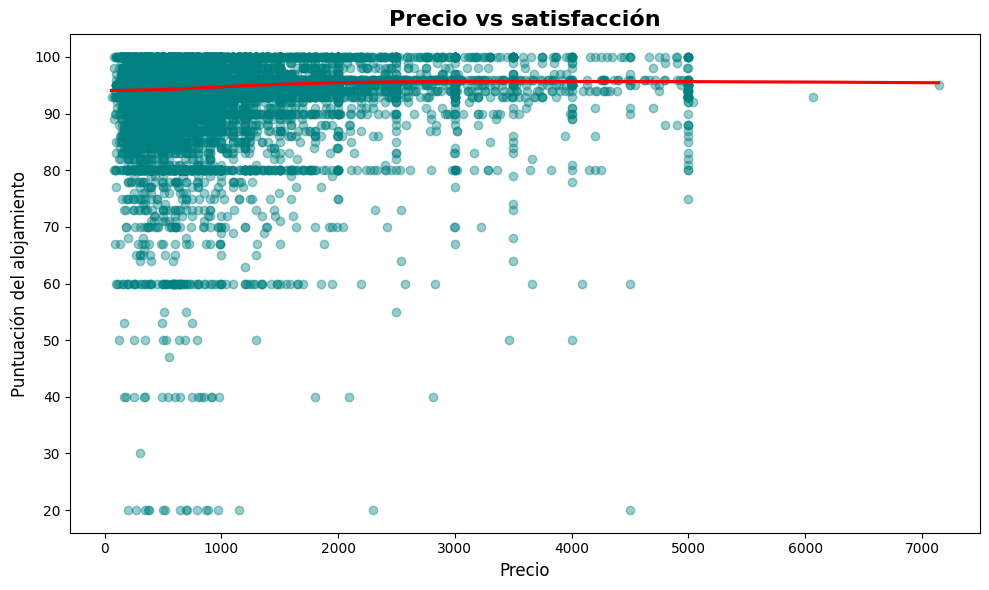

In [12]:
plt.figure(figsize=(10,6))
sns.regplot(
    data=df,
    x='price',
    y='review_scores_rating',
    scatter_kws={'alpha':0.4, 'color':'teal'},  # verde agua
    line_kws={'color':'red'},
    lowess=True
)
plt.title("Precio vs satisfacción", fontsize=16, weight='bold')
plt.xlabel("Precio", fontsize=12)
plt.ylabel("Puntuación del alojamiento", fontsize=12)
plt.tight_layout()
plt.show()


Hay mucha dispersión: los puntos están bastante alejados de la línea, lo que indica que el precio no explica bien la variación en las puntuaciones. No hay una relación clara entre pagar más y recibir mejor satisfacción.

Ni los precios ni las puntuaciones de satisfacción siguen una distribución normal, lo que viola el supuesto de normalidad de Pearson.
Esto ya justifica que Spearman sea más apropiado para analizar la relación entre precio y rating.


-> Ambos coeficientes son muy bajos, por lo que se observa una relación muy débil entre precio y rating.
El hecho de que Spearman > Pearson sugiere que la relación puede ser monótona pero no estrictamente lineal — es decir, quizás los precios más altos tienden a ratings algo mejores, pero no en proporción constante.

Conclusión global:

No hay una relación lineal fuerte entre el precio y la satisfacción general. Los huéspedes no parecen valorar más (ni menos) los alojamientos por ser más caros, al menos de forma directa.

Aunque los precios varían mucho entre ciudades y alojamientos, las puntuaciones de los huéspedes se mantienen altas en casi todos los casos. Esto sugiere que el precio no es un factor determinante en la satisfacción, y que otros aspectos (como limpieza, ubicación o atención del anfitrión) pueden ser más importantes.

## Test de Shapiro:

In [13]:
results_norm = []

for city, g in df.groupby('city'):
    if len(g) > 10:  
        sample_price = g['price'].sample(5000, random_state=42) if len(g) > 5000 else g['price']
        sample_rating = g['review_scores_rating'].sample(5000, random_state=42) if len(g) > 5000 else g['review_scores_rating']

        w_price, p_price = shapiro(sample_price)
        w_rating, p_rating = shapiro(sample_rating)

        results_norm.append({
        'city': city,
        'shapiro_price_W': round(w_price, 3),
        'shapiro_price_p': round(p_price, 3),
        'shapiro_rating_W': round(w_rating, 3),
        'shapiro_rating_p': round(p_rating, 3)
    })
        

shapiro_df = pd.DataFrame(results_norm).set_index('city')
print(shapiro_df)



           shapiro_price_W  shapiro_price_p  shapiro_rating_W  \
city                                                            
Barcelona            0.734              0.0             0.788   
Girona               0.809              0.0             0.635   
Madrid               0.698              0.0             0.694   
Mallorca             0.906              0.0             0.597   
Menorca              0.914              0.0             0.609   
Málaga               0.764              0.0             0.826   
Sevilla              0.712              0.0             0.719   
Valencia             0.666              0.0             0.719   

           shapiro_rating_p  
city                         
Barcelona               0.0  
Girona                  0.0  
Madrid                  0.0  
Mallorca                0.0  
Menorca                 0.0  
Málaga                  0.0  
Sevilla                 0.0  
Valencia                0.0  


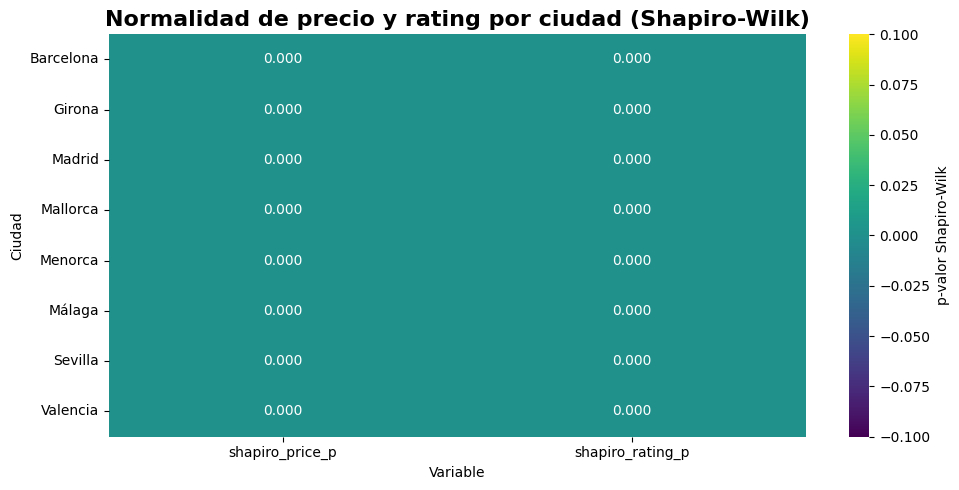

In [14]:
plt.figure(figsize=(10,5))
sns.heatmap(
    shapiro_df[['shapiro_price_p','shapiro_rating_p']], 
    annot=True, fmt=".3f", cmap="viridis", 
    cbar_kws={'label': 'p-valor Shapiro-Wilk'}
)
plt.title("Normalidad de precio y rating por ciudad (Shapiro-Wilk)", fontsize=16, weight='bold')
plt.xlabel("Variable")
plt.ylabel("Ciudad")
plt.tight_layout()
plt.show()


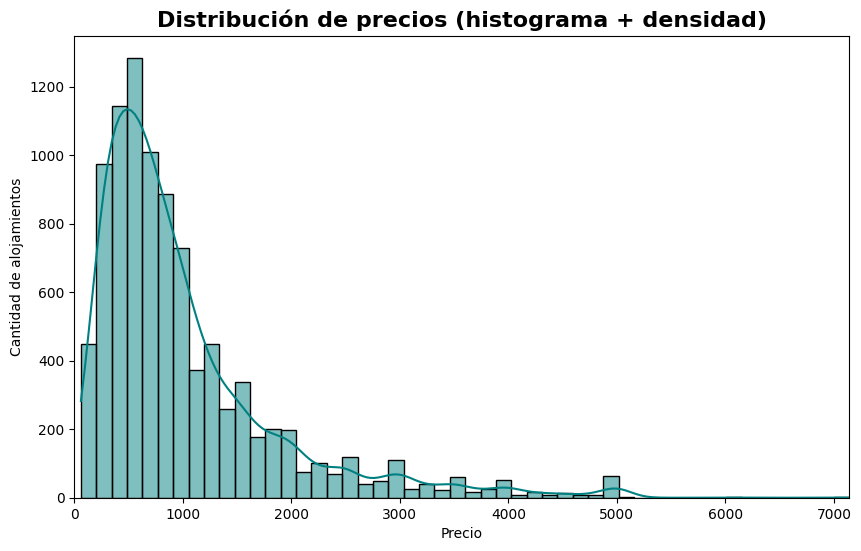

In [15]:
plt.figure(figsize=(10,6))
sns.histplot(df['price'].dropna(), bins=50, kde=True, color='teal')
plt.title("Distribución de precios (histograma + densidad)", fontsize=16, weight='bold')
plt.xlabel("Precio")
plt.ylabel("Cantidad de alojamientos")
plt.xlim(0, df['price'].quantile(1)) 
plt.show()


En general, price tiene una cola larga hacia la derecha (asimetría positiva): la mayoría de los precios están concentrados en valores bajos o medios, pero hay algunos precios muy altos que "estiran" la distribución hacia la derecha.

Los valores de W (entre 0.66 y 0.89) están bastante lejos de 1, lo que refuerza la idea de que las distribuciones de price y review_scores_rating no son normales.

review_scores_rating suele estar sesgado hacia valores altos (la mayoría de los alojamientos tienen buenos ratings, con pocos ratings bajos).

Debemos basar interpretaciones en la correlación de Spearman, no en Pearson.
Spearman es robusto ante asimetrías y detecta la relación monótona ascendente (ligeramente curvada) que se ve en gráficos con lowess = true.

## Correlación de Spearman

In [16]:
results = []

for city, g in df.groupby('city'):
    if len(g) > 2:  # al menos 3 datos para calcular
        spearman_corr, spearman_p = spearmanr(g['price'], g['review_scores_rating'])

        results.append({
            'city': city,
            'spearman_corr': round(spearman_corr, 3),
            'spearman_p': round(spearman_p, 3)
        })

corr_tests = pd.DataFrame(results).set_index('city')
print(corr_tests)

           spearman_corr  spearman_p
city                                
Barcelona         -0.044       0.022
Girona             0.131       0.000
Madrid             0.062       0.004
Mallorca           0.144       0.000
Menorca            0.029       0.679
Málaga             0.147       0.001
Sevilla            0.073       0.109
Valencia           0.071       0.107


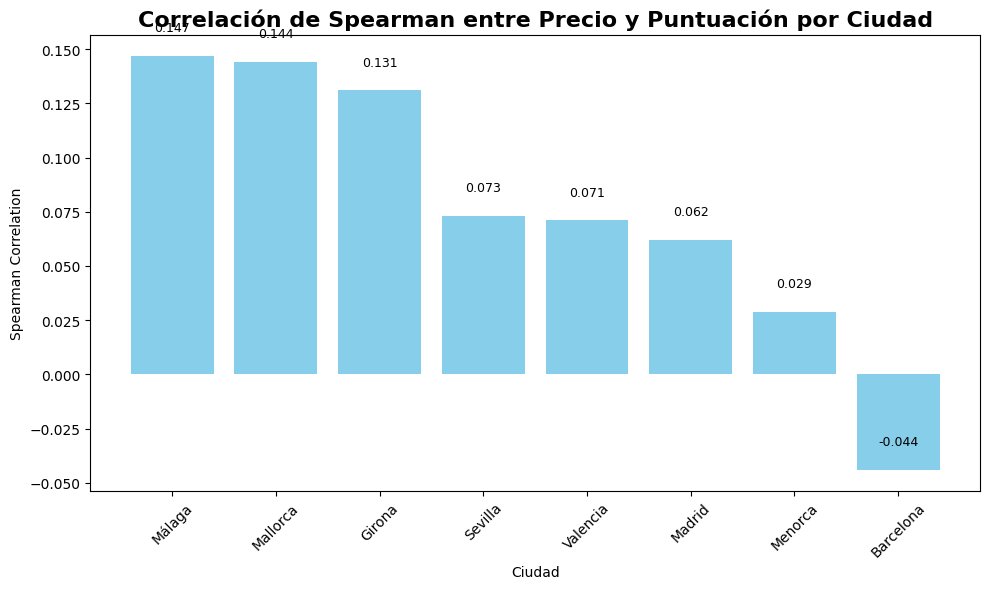

In [17]:
# Ordenar por correlación Spearman de mayor a menor
corr_sorted = corr_tests.sort_values(by='spearman_corr', ascending=False)

# Crear gráfico de barras
plt.figure(figsize=(10,6))
bars = plt.bar(corr_sorted.index, corr_sorted['spearman_corr'], color='skyblue')

# Añadir etiquetas con el valor en cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
             f"{height:.3f}", ha='center', va='bottom', fontsize=9)

# Título y etiquetas
plt.title("Correlación de Spearman entre Precio y Puntuación por Ciudad", fontsize=16, weight='bold')
plt.ylabel("Spearman Correlation")
plt.xlabel("Ciudad")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Girona, Mallorca, Málaga, Correlación débil pero positiva, significativa. Precios más altos tienden a tener ligeramente mejor rating.

Menorca: Correlación débil y no significativa. No hay evidencia de relación.

Madrid, Sevilla, Valencia: Correlación muy débil positiva, significativa pero poco relevante.

Barcelona: relación negativa.

En todas, la magnitud de la correlación (< 0.15) indica que el precio explica menos del 2% de la variabilidad en la satisfacción (porque 𝑟2 ≈ 0.02).

En general, la relación precio ↔ rating es muy débil.

## Correlación precio y satisfacción por ciudad

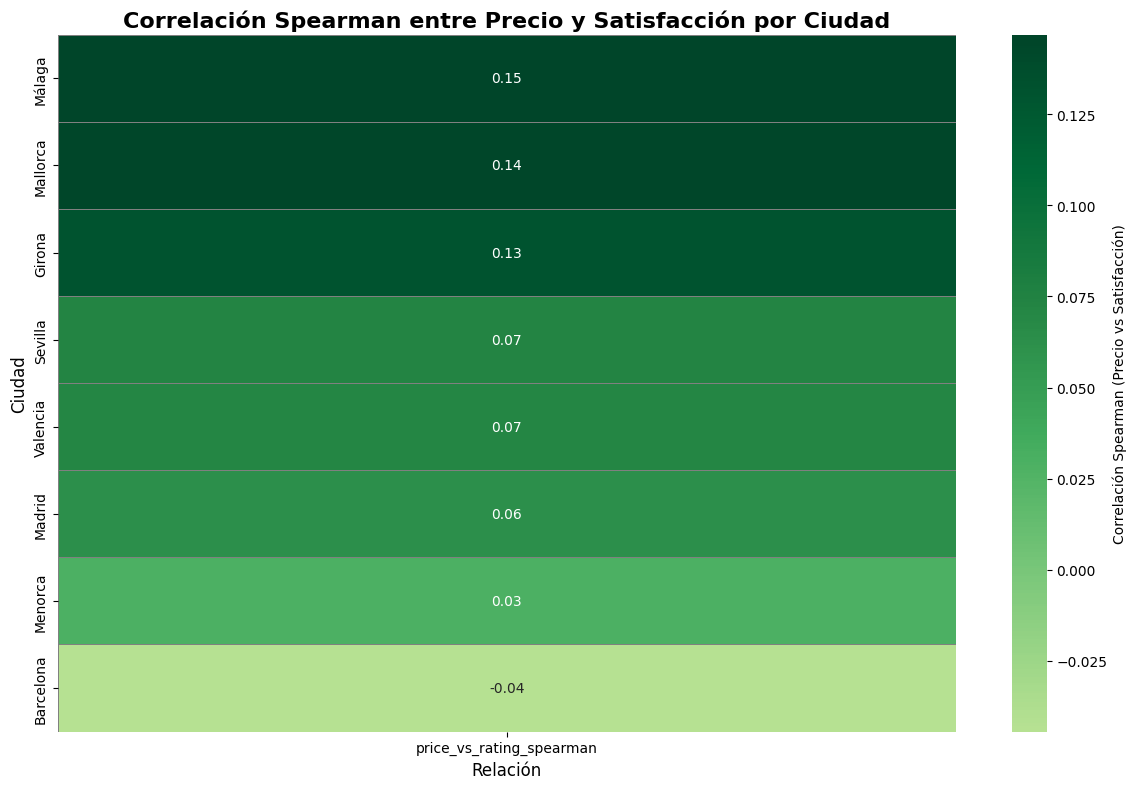

In [18]:
corr_data = []

for city, g in df.groupby('city'):
    if len(g) > 1:  # solo calcular si hay suficientes datos
        corr = g[['price', 'review_scores_rating']].corr(method='spearman').iloc[0, 1]
        corr_data.append({'city': city, 'price_vs_rating_spearman': corr})

corr_df = pd.DataFrame(corr_data).set_index('city')

# --- 4. Ordenar ciudades por correlación ---
corr_sorted = corr_df.sort_values(by='price_vs_rating_spearman', ascending=False)

# --- 5. Visualización con heatmap ---
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_sorted,
    annot=True,
    fmt=".2f",
    cmap="YlGn",  
    center=0,
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Correlación Spearman (Precio vs Satisfacción)'}
)

plt.title("Correlación Spearman entre Precio y Satisfacción por Ciudad", fontsize=16, weight='bold')
plt.xlabel("Relación", fontsize=12)
plt.ylabel("Ciudad", fontsize=12)
plt.tight_layout()
plt.show()


## Métricas por ciudad

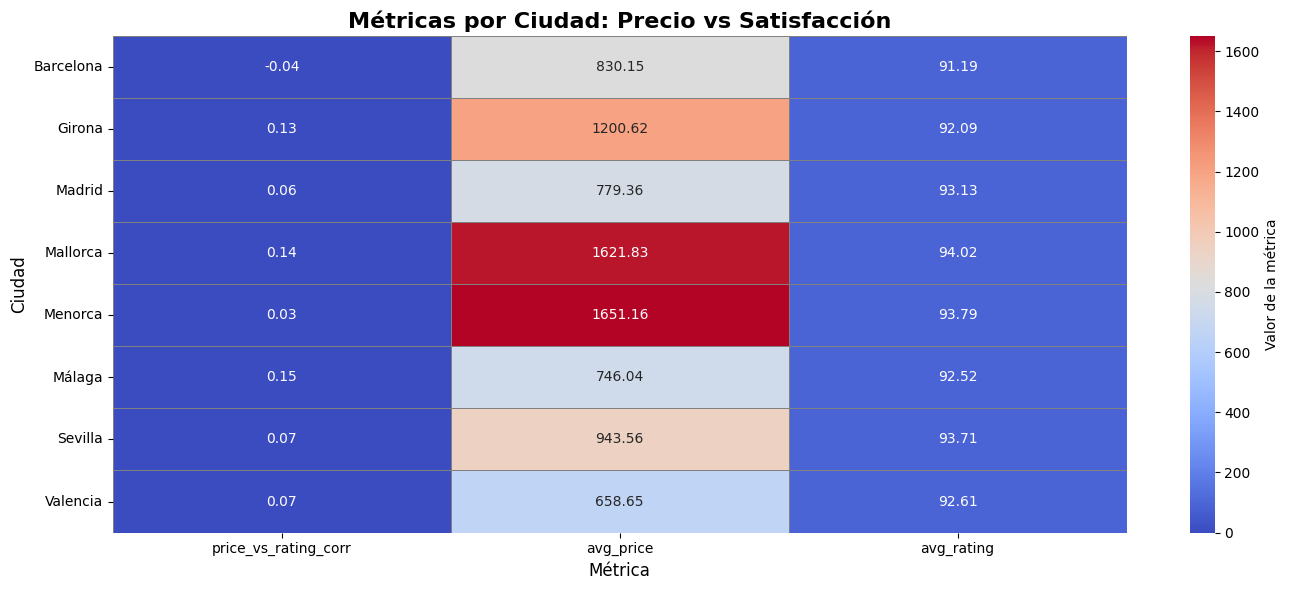

In [19]:
metrics = []

for city, g in df.groupby('city'):
    if len(g) > 1:  # mínimo 2 datos para correlación
        corr = g[['price', 'review_scores_rating']].corr(method='spearman').iloc[0,1]
        avg_price = g['price'].mean()
        avg_rating = g['review_scores_rating'].mean()
        count = len(g)
        metrics.append({
            'city': city,
            'price_vs_rating_corr': corr,
            'avg_price': avg_price,
            'avg_rating': avg_rating
        })

metrics_df = pd.DataFrame(metrics).set_index('city')

# Heatmap con varias métricas
plt.figure(figsize=(14, len(metrics_df)*0.5 + 2))
sns.heatmap(
    metrics_df, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    linewidths=0.5, 
    linecolor='gray',
    cbar_kws={'label': 'Valor de la métrica'}
)

plt.title("Métricas por Ciudad: Precio vs Satisfacción", fontsize=16, weight='bold')
plt.xlabel("Métrica", fontsize=12)
plt.ylabel("Ciudad", fontsize=12)
plt.tight_layout()
plt.show()


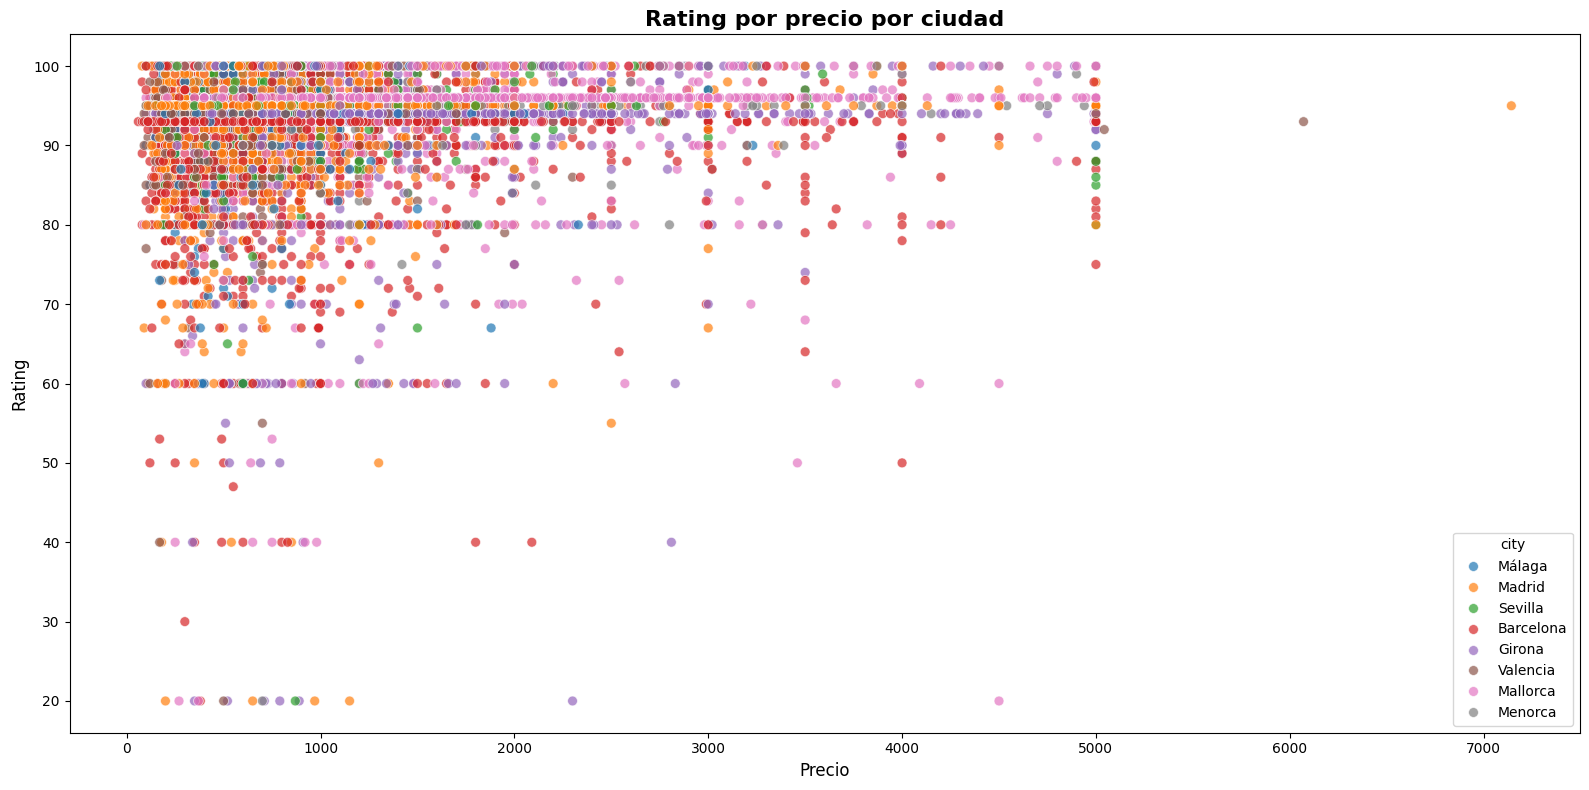

In [20]:
plt.figure(figsize=(16, 8))
sns.scatterplot(
    data=df,
    x='price',
    y='review_scores_rating',
    hue='city',     
    alpha=0.7,       # transparencia para ver puntos superpuestos
    palette='tab10', 
    s=50             
)
plt.title("Rating por precio por ciudad", fontsize=16, weight='bold')
plt.xlabel("Precio", fontsize=12)
plt.ylabel("Rating", fontsize=12)
plt.tight_layout()
plt.show()

## Facetgrid por ciudades

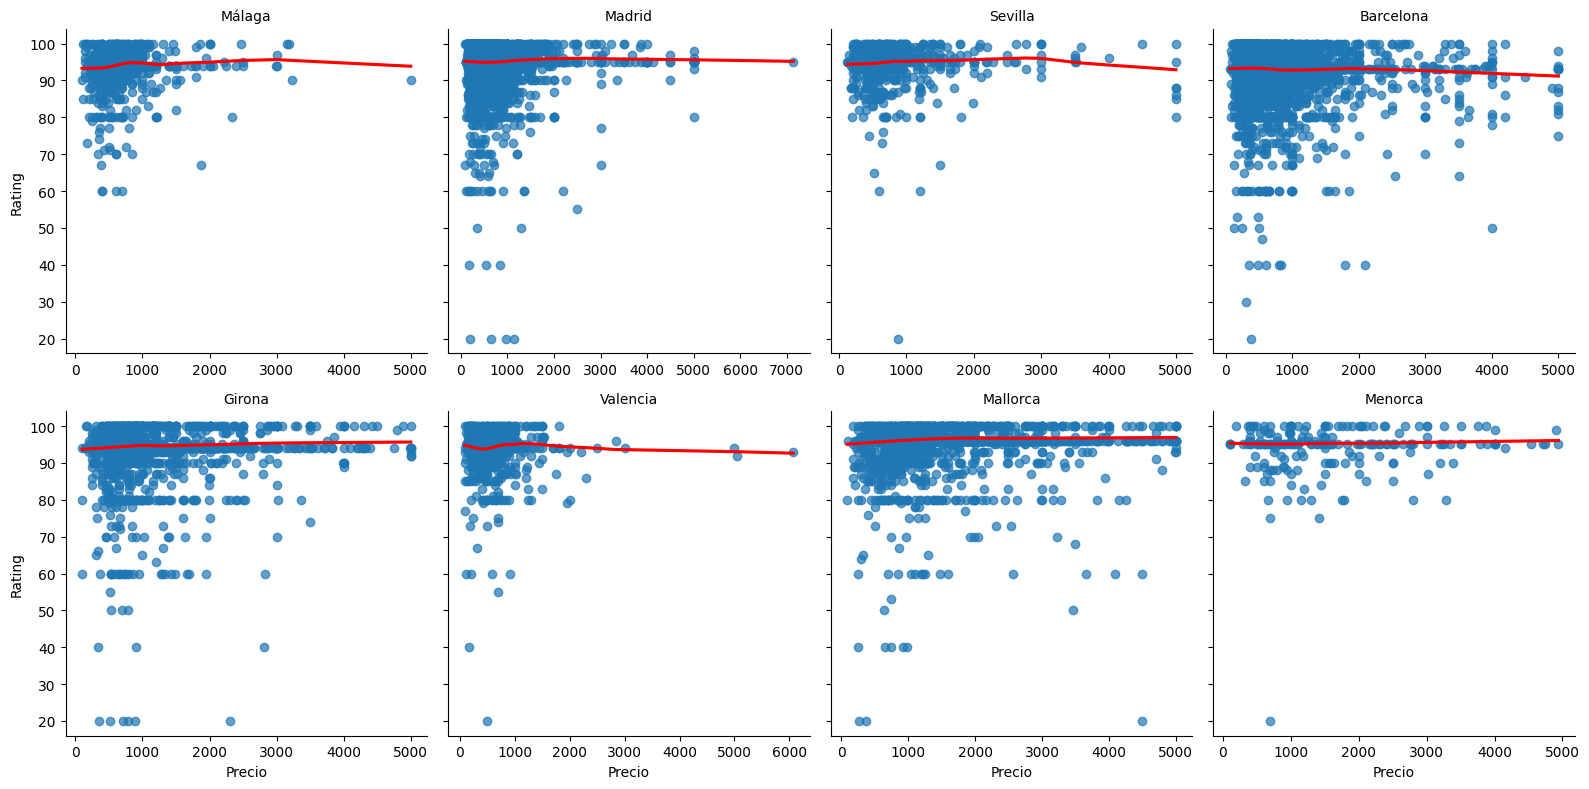

In [21]:
g = sns.FacetGrid(df, col='city', col_wrap=4, height=4, sharex=False, sharey=True)
g.map_dataframe(
    sns.regplot,
    x='price',
    y='review_scores_rating',
    scatter_kws={'alpha': 0.7},
    line_kws={'color': 'red'},
    lowess=True 
)
g.set_axis_labels("Precio", "Rating")
g.set_titles(col_template="{col_name}")
plt.tight_layout()
plt.show()

- Barcelona: Tendencia casi plana o ligeramente negativa; pagar más no se asocia con mejor rating de forma consistente.
- Girona: Pendiente más claramente positiva; a mayor precio, el rating tiende a subir modestamente.
- Madrid: Positiva pero muy suave; impacto práctico bajo.
- Mallorca: Positiva y algo más marcada que la media; sugiere relación monótona débil.
- Menorca: Relación poco clara; dispersión alta y línea casi plana.
- Málaga: Ligera positividad; efecto pequeño pero visible.
- Sevilla: Tendencia muy tenue; difícil extraer una señal sólida.
- Valencia: Señal débil; posible efecto techo que aplana la tendencia.

## División de precio por rangos cuartiles:

Límites de los cuantiles de precio:
[  60.  400.  600.  900. 1450. 7143.]


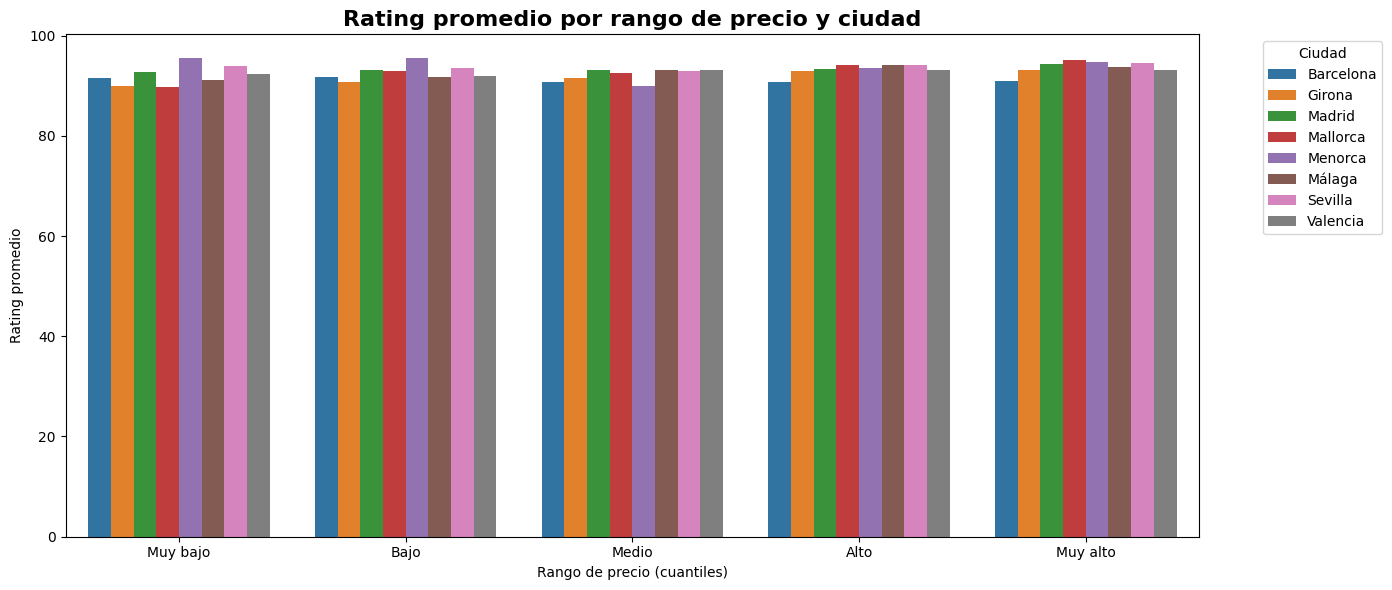


Promedio de rating por rango de precio y ciudad:


,city,price_quantil,mean,count
0,Barcelona,Muy bajo,91.444319,889
1,Barcelona,Bajo,91.734807,543
2,Barcelona,Medio,90.687215,438
3,Barcelona,Alto,90.792237,438
4,Barcelona,Muy alto,90.863014,365
5,Girona,Muy bajo,89.925000,80
6,Girona,Bajo,90.717842,241
7,Girona,Medio,91.620253,395
8,Girona,Alto,92.885714,385
9,Girona,Muy alto,93.162011,358


In [22]:
# Análisis por cuantiles de precio
# Dividir el precio en 5 grupos
price_quantil, bins = pd.qcut(
    df['price'], 
    q=5, 
    labels=['Muy bajo','Bajo','Medio','Alto','Muy alto'], 
    duplicates='drop', 
    retbins=True
)

print("Límites de los cuantiles de precio:")
print(bins)


# Calcular promedio de rating por rango de precio y ciudad

# Dividir el precio en 5 grupos (cuantiles)
df['price_quantil'], bins = pd.qcut(
    df['price'], 
    q=5, 
    labels=['Muy bajo','Bajo','Medio','Alto','Muy alto'], 
    duplicates='drop', 
    retbins=True
)


rating_by_quantil = (
    df.groupby(['city','price_quantil'])['review_scores_rating']
    .agg(['mean','count'])
    .reset_index()
)

# Visualización del rating promedio por rango
plt.figure(figsize=(14,6))
sns.barplot(
    data=rating_by_quantil,
    x='price_quantil', y='mean', hue='city',
    palette='tab10'
)
plt.title("Rating promedio por rango de precio y ciudad", fontsize=16, weight='bold')
plt.xlabel("Rango de precio (cuantiles)")
plt.ylabel("Rating promedio")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', title='Ciudad')
plt.tight_layout()
plt.show()

# Mostrar tabla resumen
print("\nPromedio de rating por rango de precio y ciudad:")
display(rating_by_quantil)


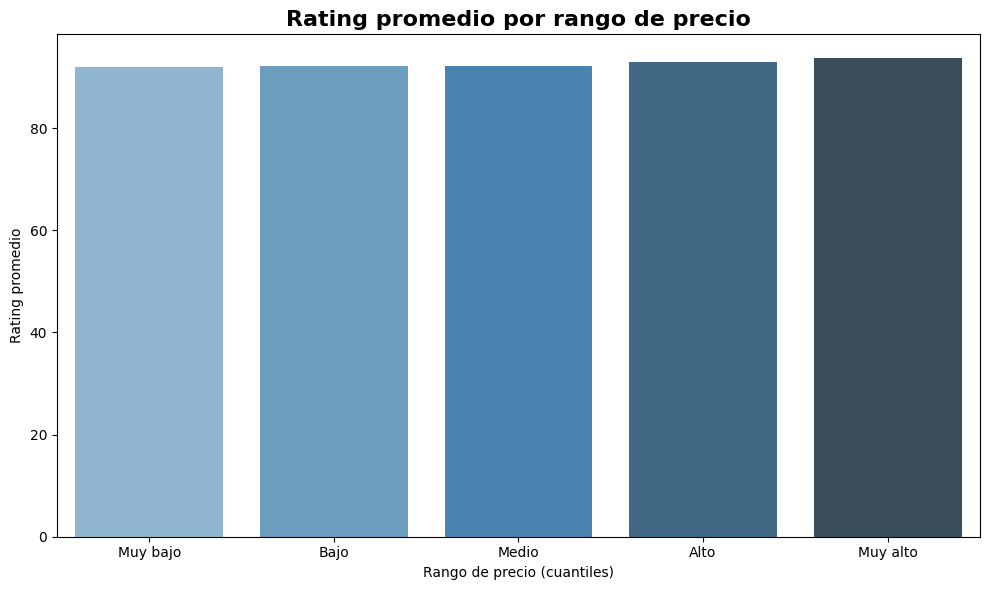


Promedio de rating por rango de precio:


,price_quantil,mean,count
0,Muy bajo,91.915594,2097
1,Bajo,92.176887,1696
2,Medio,92.131282,1950
3,Alto,92.877654,1790
4,Muy alto,93.678057,1873


In [23]:
rating_by_quantil = (
    df.groupby('price_quantil')['review_scores_rating']
    .agg(['mean', 'count'])
    .reset_index()
)


plt.figure(figsize=(10,6))
sns.barplot(
    data=rating_by_quantil,
    x='price_quantil', y='mean',
    palette='Blues_d'
)
plt.title("Rating promedio por rango de precio", fontsize=16, weight='bold')
plt.xlabel("Rango de precio (cuantiles)")
plt.ylabel("Rating promedio")
plt.tight_layout()
plt.show()


print("\nPromedio de rating por rango de precio:")
display(rating_by_quantil)

In [24]:
# 1) PREPARO DO DATASET

#Centra el precio y crea un término cuadrático para análisis más robusto y muestra la media de precio usada en el centrado.

TARGET = 'review_scores_rating'
PRICE = 'price'
CITY = 'city'

# Copia de trabajo
data = df[[CITY, PRICE, TARGET]].copy()

data = data.dropna(subset=[PRICE, TARGET, CITY])

# (Opcional) Winsorización ligera de precios para reducir outliers extremos (percentil 1º–99º)

low, high = data[PRICE].quantile([0.01, 0.99]).values
data[PRICE] = data[PRICE].clip(lower=low, upper=high)

# Verifica escala del rating: convierte de 0–5 a 0–100, si es necesario
if data[TARGET].max() <= 5.5:  # margem
    data[TARGET] = data[TARGET] * 20.0

# Centra el precio (mejora interpretación y reduce multicolinealidad en el término cuadrático)

price_mean = data[PRICE].mean()
data['price_c'] = data[PRICE] - price_mean
data['price_c2'] = data['price_c']**2

print(f"Media de precio usada para centrado: {price_mean:,.2f}")

Media de precio usada para centrado: 1,007.64


In [25]:
# =========================
# 2) MODELOS
# =========================

# Modelo A (general, no condicionado a la ciudad): SAT ~ price_c + price_c^2

modelA = smf.ols(f'{TARGET} ~ price_c + price_c2', data=data).fit(cov_type='HC3')
print("\n=== Modelo A (general; no lineal) - Errores robustos HC3 ===")
print(modelA.summary())

# Modelo B (con moderación por ciudad): incluye interacciones con C(city)
# Nota: C(city) crea variables dummy automáticamente

modelB = smf.ols(f'{TARGET} ~ C({CITY})*price_c + C({CITY})*price_c2', data=data).fit(cov_type='HC3')
print("\n=== Modelo B (moderación por ciudad; no lineal) - Errores robustos HC3 ===")
print(modelB.summary())


=== Modelo A (general; no lineal) - Errores robustos HC3 ===
                             OLS Regression Results                             
Dep. Variable:     review_scores_rating   R-squared:                       0.007
Model:                              OLS   Adj. R-squared:                  0.006
Method:                   Least Squares   F-statistic:                     33.00
Date:                  Thu, 13 Nov 2025   Prob (F-statistic):           5.24e-15
Time:                          11:25:45   Log-Likelihood:                -32975.
No. Observations:                  9406   AIC:                         6.596e+04
Df Residuals:                      9403   BIC:                         6.598e+04
Df Model:                             2                                         
Covariance Type:                    HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------

In [26]:

# =========================
# 3) PREÇO ÓTIMO (vértice da parábola)
# =========================
# Para y = b0 + b1*x + b2*x^2, o x* que maximiza y é -b1/(2*b2)
def vertex(b1, b2):
    if b2 == 0:
        return np.nan
    return -b1 / (2.0 * b2)

# 3.1) Global (Modelo A)
b1_A = modelA.params.get('price_c', np.nan)
b2_A = modelA.params.get('price_c2', np.nan)
x_star_c_global = vertex(b1_A, b2_A)   # em preço centrado
x_star_global = x_star_c_global + price_mean
print("\n--- Preço ótimo (GLOBAL, Modelo A) ---")
print(f"b1={b1_A:.6f}, b2={b2_A:.6f}")
print(f"Preço* (centrado) = {x_star_c_global:,.2f}")
print(f"Preço* (original)  = {x_star_global:,.2f}")
    


--- Preço ótimo (GLOBAL, Modelo A) ---
b1=0.001161, b2=-0.000000
Preço* (centrado) = 1,976.94
Preço* (original)  = 2,984.58


In [27]:

# 3.2) Por cidade (Modelo B)
# Para cada cidade, a inclinação e a curvatura mudam (b1, b2 efetivos)
cities = sorted(data[CITY].unique())
rows = []
for c in cities:
    # Coeficientes base (categoria de referência) + deltas para a cidade c (se existirem)
    # Referência é a primeira cidade em ordem alfabética por padrão do patsy/statsmodels.
    # Pegamos b1_base = coef de price_c sem interação; b2_base = coef de price_c2 sem interação
    b1_base = modelB.params.get('price_c', 0.0)
    b2_base = modelB.params.get('price_c2', 0.0)

    # Nomes das interações no modelo (padrão de statsmodels):
    # C(city)[T.<nome>]:price_c  e  C(city)[T.<nome>]:price_c2
    if c != cities[0]:
        b1_delta = modelB.params.get(f'C({CITY})[T.{c}]:price_c', 0.0)
        b2_delta = modelB.params.get(f'C({CITY})[T.{c}]:price_c2', 0.0)
    else:
        b1_delta, b2_delta = 0.0, 0.0

    b1_c = b1_base + b1_delta
    b2_c = b2_base + b2_delta
    x_star_c = vertex(b1_c, b2_c)      # centrado
    x_star = x_star_c + price_mean     # original
    rows.append([c, b1_c, b2_c, x_star])

opt_df = pd.DataFrame(rows, columns=['city', 'b1_price', 'b2_price2', 'optimal_price'])
opt_df = opt_df.sort_values('city')
print("\n--- Preço ótimo por cidade (Modelo B) ---")
print(opt_df.to_string(index=False))



--- Preço ótimo por cidade (Modelo B) ---
     city  b1_price     b2_price2  optimal_price
Barcelona -0.000330 -3.860955e-08   -3264.769538
   Girona  0.001614 -2.584145e-07    4131.300494
   Madrid  0.000858 -1.424199e-07    4019.120720
 Mallorca  0.002781 -8.814514e-07    2585.113119
  Menorca  0.000278  1.719872e-07     200.744784
   Málaga  0.002062 -7.798039e-07    2329.627486
  Sevilla  0.000886 -3.674283e-07    2213.596881
 Valencia  0.001128 -4.064778e-07    2394.817346


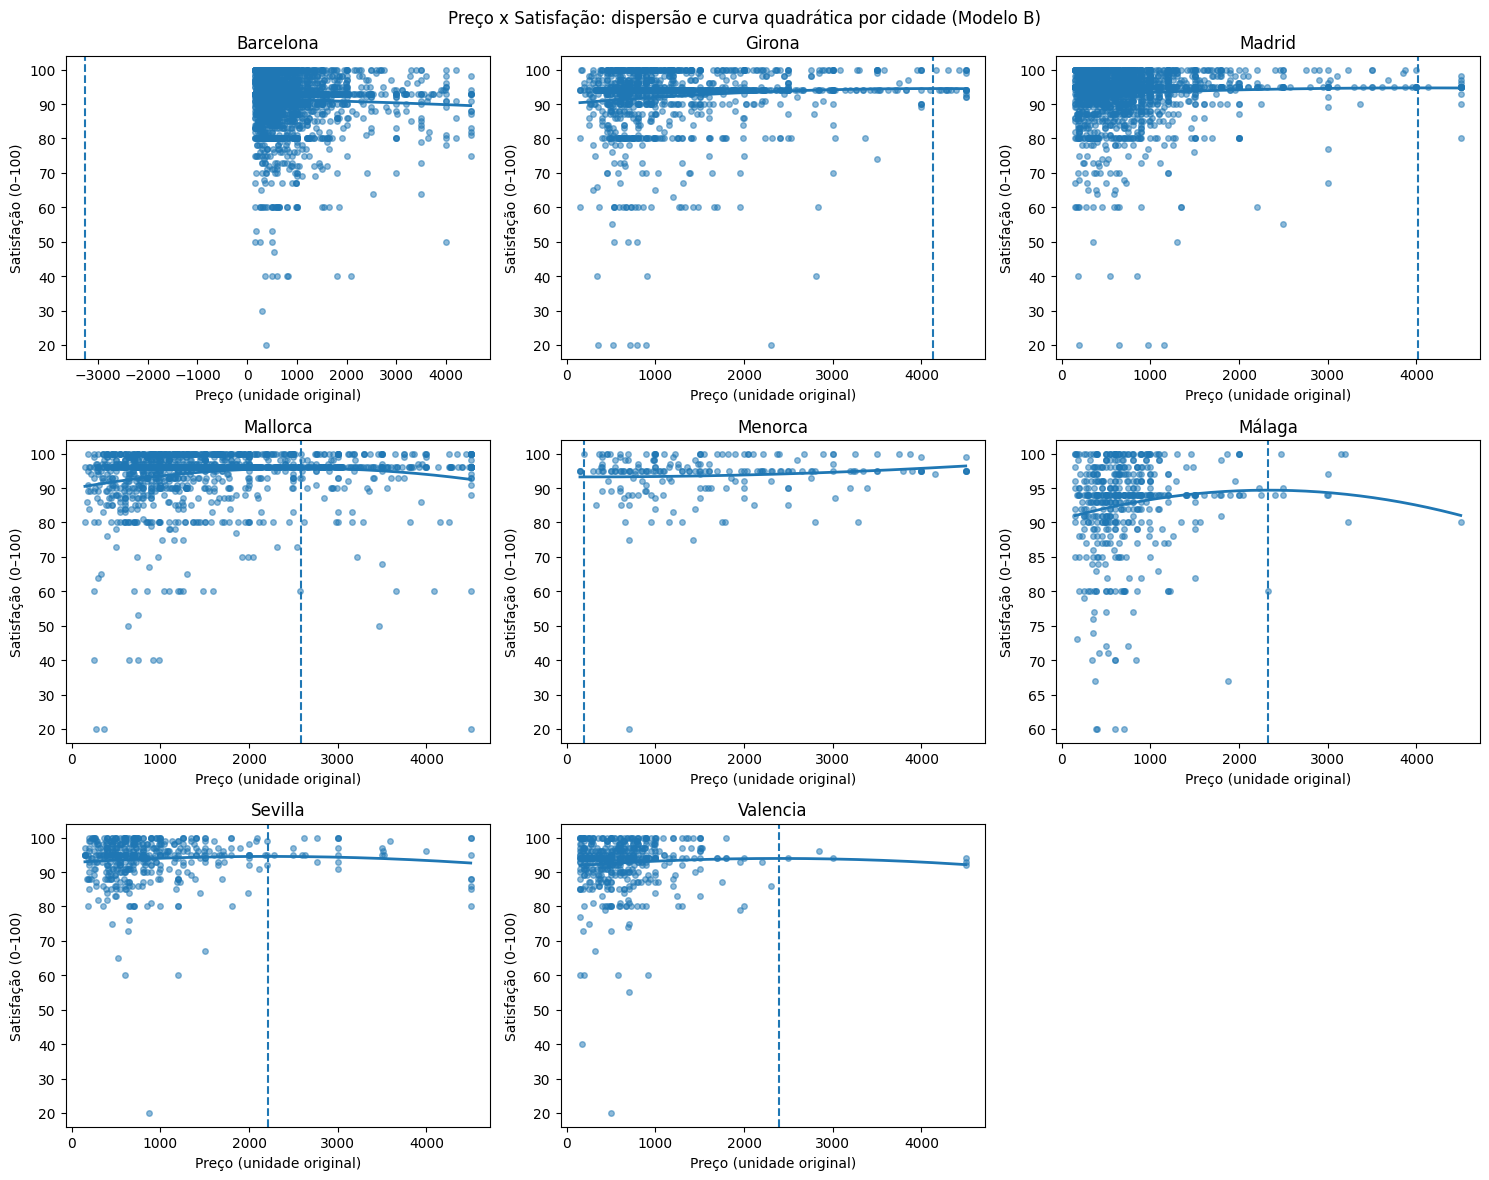

In [28]:

# =========================
# 4) GRÁFICOS (MATPLOTLIB)
# =========================
# 4.1) Dispersão por cidade (subplots) + curva quadrática ajustada (Modelo B)
# Para cada cidade, plota pontos e a curva y_hat(x) usando os coeficientes por cidade

def predict_city_curve(model, city_name, x_vals_c):  # x_vals em escala centrada
    # Recupera coeficientes efetivos b0, b1, b2 para a cidade
    # Para city de referência (primeira), b0,b1,b2 são os coeficientes base.
    # Para demais, soma interações/dummies.
    params = model.params

    # intercepto base
    b0 = params.get('Intercept', 0.0)
    b1 = params.get('price_c', 0.0)
    b2 = params.get('price_c2', 0.0)

    ref_city = cities[0]
    if city_name != ref_city:
        b0 += params.get(f'C({CITY})[T.{city_name}]', 0.0)
        b1 += params.get(f'C({CITY})[T.{city_name}]:price_c', 0.0)
        b2 += params.get(f'C({CITY})[T.{city_name}]:price_c2', 0.0)

    y_hat = b0 + b1 * x_vals_c + b2 * (x_vals_c**2)
    return y_hat

# Define o range comum de preços por cidade
min_p = data[PRICE].min()
max_p = data[PRICE].max()
x_plot = np.linspace(min_p, max_p, 200)
x_plot_c = x_plot - price_mean

# Layout
n = len(cities)
cols = 3
rows_sub = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows_sub, cols, figsize=(5*cols, 4*rows_sub), squeeze=False)
fig.suptitle('Preço x Satisfação: dispersão e curva quadrática por cidade (Modelo B)')

for i, c in enumerate(cities):
    r, co = divmod(i, cols)
    ax = axes[r, co]

    # pontos
    subset = data[data[CITY] == c]
    ax.scatter(subset[PRICE], subset[TARGET], s=16, alpha=0.5)

    # curva
    y_hat = predict_city_curve(modelB, c, x_plot_c)
    ax.plot(x_plot, y_hat, linewidth=2)

    # preço ótimo
    opt_price = opt_df.loc[opt_df['city'] == c, 'optimal_price'].iloc[0]
    if np.isfinite(opt_price):
        ax.axvline(opt_price, linestyle='--')

    ax.set_title(c)
    ax.set_xlabel('Preço (unidade original)')
    ax.set_ylabel('Satisfação (0–100)')

# esconde eixos vazios se houver
for j in range(i+1, rows_sub*cols):
    r, co = divmod(j, cols)
    axes[r, co].axis('off')

plt.tight_layout()
plt.show()


In [29]:

# =========================
# 5) SAÍDAS RESUMIDAS
# =========================
# Tabela com preço ótimo por cidade e R² dos modelos
out = opt_df.copy()
out['R2_ModeloA'] = round(modelA.rsquared, 4)
out['R2_ModeloB'] = round(modelB.rsquared, 4)
print("\nResumo final:")
print(out.to_string(index=False))
    


Resumo final:
     city  b1_price     b2_price2  optimal_price  R2_ModeloA  R2_ModeloB
Barcelona -0.000330 -3.860955e-08   -3264.769538      0.0066      0.0252
   Girona  0.001614 -2.584145e-07    4131.300494      0.0066      0.0252
   Madrid  0.000858 -1.424199e-07    4019.120720      0.0066      0.0252
 Mallorca  0.002781 -8.814514e-07    2585.113119      0.0066      0.0252
  Menorca  0.000278  1.719872e-07     200.744784      0.0066      0.0252
   Málaga  0.002062 -7.798039e-07    2329.627486      0.0066      0.0252
  Sevilla  0.000886 -3.674283e-07    2213.596881      0.0066      0.0252
 Valencia  0.001128 -4.064778e-07    2394.817346      0.0066      0.0252


In [30]:
import statsmodels.api as sm

X = sm.add_constant(df['price'])
model = sm.OLS(df['review_scores_rating'], X).fit()
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     review_scores_rating   R-squared:                       0.005
Model:                              OLS   Adj. R-squared:                  0.005
Method:                   Least Squares   F-statistic:                     46.19
Date:                  Thu, 13 Nov 2025   Prob (F-statistic):           1.14e-11
Time:                          11:25:46   Log-Likelihood:                -32983.
No. Observations:                  9406   AIC:                         6.597e+04
Df Residuals:                      9404   BIC:                         6.598e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         91.8798      0.128

In [31]:
import statsmodels.formula.api as smf
import numpy as np

# Cria o termo quadrático
df['price_sq'] = df['price']**2

# Modelo quadrático
model_quad = smf.ols('review_scores_rating ~ price + price_sq', data=df).fit()
print(model_quad.summary())


                             OLS Regression Results                             
Dep. Variable:     review_scores_rating   R-squared:                       0.007
Model:                              OLS   Adj. R-squared:                  0.006
Method:                   Least Squares   F-statistic:                     30.80
Date:                  Thu, 13 Nov 2025   Prob (F-statistic):           4.63e-14
Time:                          11:25:46   Log-Likelihood:                -32975.
No. Observations:                  9406   AIC:                         6.596e+04
Df Residuals:                      9403   BIC:                         6.598e+04
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     91.3304      0.190

In [32]:
b1 = model_quad.params['price']
b2 = model_quad.params['price_sq']

if b2 != 0:
    price_opt = -b1 / (2*b2)
    print(f"Preço ótimo estimado: {price_opt:.2f}")
else:
    print("O termo quadrático não é significativo — sem ponto ótimo.")


Preço ótimo estimado: 3170.17


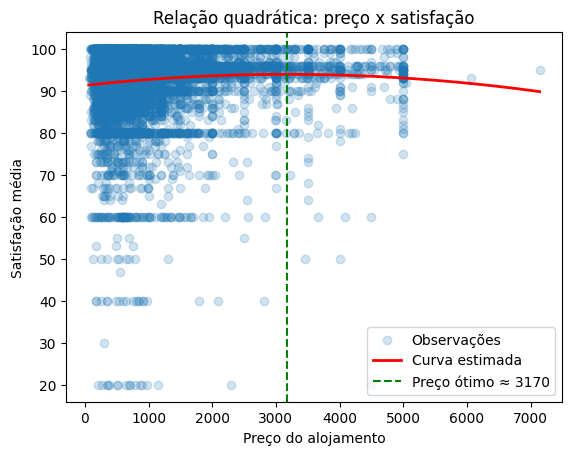

In [33]:
import matplotlib.pyplot as plt

# Previsão da curva
x = np.linspace(df['price'].min(), df['price'].max(), 200)
y_pred = model_quad.params['Intercept'] + b1*x + b2*(x**2)

plt.scatter(df['price'], df['review_scores_rating'], alpha=0.2, label='Observações')
plt.plot(x, y_pred, color='red', linewidth=2, label='Curva estimada')
plt.axvline(price_opt, color='green', linestyle='--', label=f'Preço ótimo ≈ {price_opt:.0f}')
plt.xlabel('Preço do alojamento')
plt.ylabel('Satisfação média')
plt.title('Relação quadrática: preço x satisfação')
plt.legend()
plt.show()


In [34]:
model_city = smf.ols('review_scores_rating ~ price * city + price_sq * city', data=df).fit()
print(model_city.summary())


                             OLS Regression Results                             
Dep. Variable:     review_scores_rating   R-squared:                       0.025
Model:                              OLS   Adj. R-squared:                  0.022
Method:                   Least Squares   F-statistic:                     10.37
Date:                  Thu, 13 Nov 2025   Prob (F-statistic):           3.12e-37
Time:                          11:25:46   Log-Likelihood:                -32887.
No. Observations:                  9406   AIC:                         6.582e+04
Df Residuals:                      9382   BIC:                         6.599e+04
Df Model:                            23                                         
Covariance Type:              nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
In